# NAME: SREENIVASAN S
# REG NO: 21BEC0256
## PROJECT TITLE: ADVANCED-TRAFFIC-SIGN-CLASSIFICATION-SYSTEM

# TASK #1: UNDERSTAND THE PROBLEM STATEMENT


- Our goal is to build a multiclassifier model based on deep learning to classify various traffic signs. 
- Dataset that we are using to train the model is **German Traffic Sign Recognition Benchmark**.
- Dataset consists of 43 classes: 
- ( 0, b'Speed limit (20km/h)') ( 1, b'Speed limit (30km/h)') ( 2, b'Speed limit (50km/h)') ( 3, b'Speed limit (60km/h)') ( 4, b'Speed limit (70km/h)') 
- ( 5, b'Speed limit (80km/h)') ( 6, b'End of speed limit (80km/h)') ( 7, b'Speed limit (100km/h)') ( 8, b'Speed limit (120km/h)') ( 9, b'No passing') 
- (10, b'No passing for vehicles over 3.5 metric tons') (11, b'Right-of-way at the next intersection') (12, b'Priority road') (13, b'Yield') (14, b'Stop') 
- (15, b'No vehicles') (16, b'Vehicles over 3.5 metric tons prohibited') (17, b'No entry')
- (18, b'General caution') (19, b'Dangerous curve to the left')
- (20, b'Dangerous curve to the right') (21, b'Double curve')
- (22, b'Bumpy road') (23, b'Slippery road')
- (24, b'Road narrows on the right') (25, b'Road work')
- (26, b'Traffic signals') (27, b'Pedestrians') (28, b'Children crossing')
- (29, b'Bicycles crossing') (30, b'Beware of ice/snow')
- (31, b'Wild animals crossing')
- (32, b'End of all speed and passing limits') (33, b'Turn right ahead')
- (34, b'Turn left ahead') (35, b'Ahead only') (36, b'Go straight or right')
- (37, b'Go straight or left') (38, b'Keep right') (39, b'Keep left')
- (40, b'Roundabout mandatory') (41, b'End of no passing')
- (42, b'End of no passing by vehicles over 3.5 metric tons')



- **Data Source** - https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

# TASK #2: GET THE DATA AND VISUALIZE IT 

In [1]:
import pickle

with open("train.p", mode='rb') as training_data:
    train = pickle.load(training_data)
with open("valid.p", mode='rb') as validation_data:
    valid = pickle.load(validation_data)
with open("test.p", mode='rb') as testing_data:
    test = pickle.load(testing_data)

In [2]:
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

label =  41


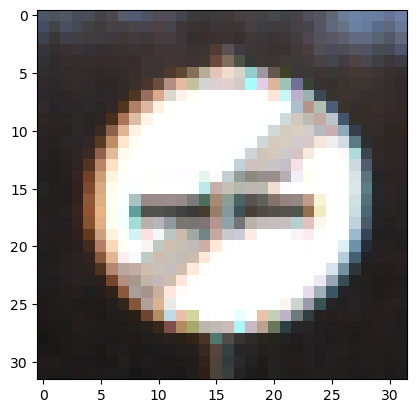

In [4]:
import numpy as np
import matplotlib.pyplot as plt
i = np.random.randint(1, len(X_test))
plt.imshow(X_test[i])
print('label = ', y_test[i])

In [3]:
X_test.shape

(12630, 32, 32, 3)

In [5]:
X_train.shape

(34799, 32, 32, 3)

In [7]:
X_validation.shape

(4410, 32, 32, 3)


- Printing 5 by 5 grid showing random traffic sign images along with their corresponding labels as their titles

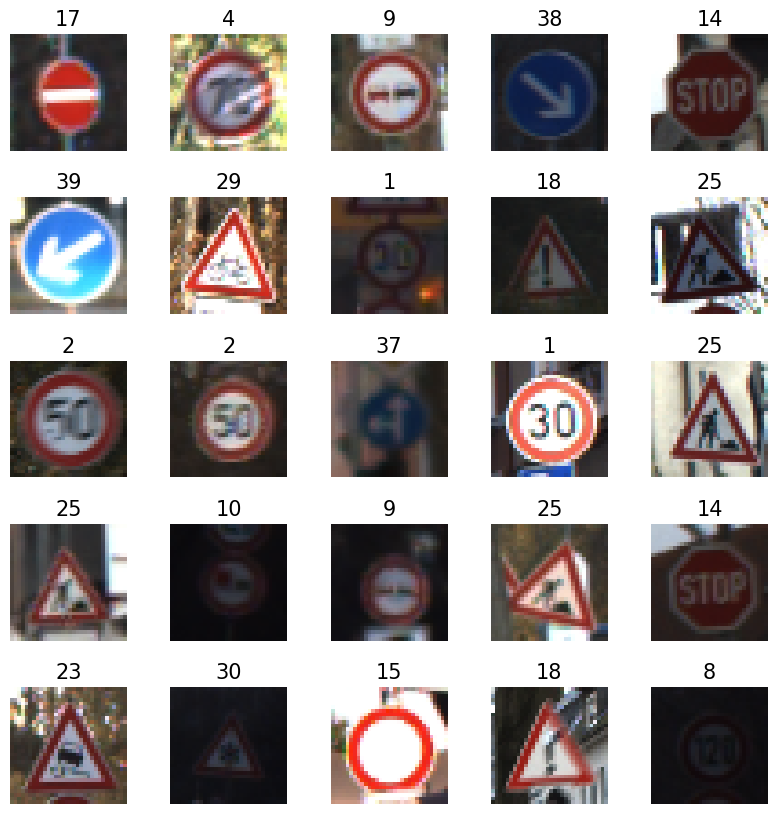

In [11]:
# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (10,10))

axes = axes.ravel() # flaten the 5 x 5 matrix into 225 array

n= len(X_test) # get the length of the training dataset

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 
    index = np.random.randint(0,n)
    axes[i].imshow(X_test[index])
    axes[i].set_title(y_test[index], fontsize = 15)
    axes[i].axis('off')
plt.subplots_adjust(hspace = 0.4)

# TASK #3: IMPORT SAGEMAKER/BOTO3, CREATE A SESSION, DEFINE S3 AND ROLE 

In [13]:
# Boto3 is the Amazon Web Services (AWS) Software Development Kit (SDK) for Python
# Boto3 allows Python developer to write software that makes use of services like Amazon S3 and Amazon EC2

import sagemaker
import boto3

# Let's create a Sagemaker session
sagemaker_session = sagemaker.Session()

# Let's define the S3 bucket and prefix that we want to use in this session
#bucket = 'sagemaker-practical' # bucket named 'sagemaker-practical' was created beforehand
prefix = 'traffic-sign-classifier' # prefix is the subfolder within the bucket.

# Let's get the execution role for the notebook instance. 
# This is the IAM role that you created when you created your notebook instance. You pass the role to the training job.
# Note that AWS Identity and Access Management (IAM) role that Amazon SageMaker can assume to perform tasks on your behalf (for example, reading training results, called model artifacts, from the S3 bucket and writing training results to Amazon S3). 
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::654654201105:role/service-role/AmazonSageMaker-ExecutionRole-20240606T025801


# TASK #4: UPLOAD THE DATA TO S3

In [14]:
# Create directory to store the training and validation data

import os
os.makedirs("./data", exist_ok = True)

In [15]:
# Save several arrays into a single file in uncompressed .npz format
# Read more here: https://numpy.org/devdocs/reference/generated/numpy.savez.html

np.savez('./data/training', image = X_train, label = y_train)
np.savez('./data/validation', image = X_test, label = y_test)

In [16]:
# Upload the training and validation data to S3 bucket

prefix = 'traffic-sign'

training_input_path   = sagemaker_session.upload_data('data/training.npz', key_prefix = prefix + '/training')
validation_input_path = sagemaker_session.upload_data('data/validation.npz', key_prefix = prefix + '/validation')

print(training_input_path)
print(validation_input_path)

s3://sagemaker-ap-south-1-654654201105/traffic-sign/training/training.npz
s3://sagemaker-ap-south-1-654654201105/traffic-sign/validation/validation.npz


# TASK #5: TRAIN THE CNN LENET MODEL USING SAGEMAKER

The model consists of the following layers: 

- STEP 1: THE FIRST CONVOLUTIONAL LAYER #1


    - Input = 32x32x3
    - Output = 28x28x6
    - Output = (Input-filter+1)/Stride* => (32-5+1)/1=28
    - Used a 5x5 Filter with input depth of 3 and output depth of 6
    - Apply a RELU Activation function to the output
    - pooling for input, Input = 28x28x6 and Output = 14x14x6


    * Stride is the amount by which the kernel is shifted when the kernel is passed over the image.

- STEP 2: THE SECOND CONVOLUTIONAL LAYER #2


    - Input = 14x14x6
    - Output = 10x10x16
    - Layer 2: Convolutional layer with Output = 10x10x16
    - Output = (Input-filter+1)/strides => 10 = 14-5+1/1
    - Apply a RELU Activation function to the output
    - Pooling with Input = 10x10x16 and Output = 5x5x16

- STEP 3: FLATTENING THE NETWORK


    - Flatten the network with Input = 5x5x16 and Output = 400

- STEP 4: FULLY CONNECTED LAYER


    - Layer 3: Fully Connected layer with Input = 400 and Output = 120
    - Apply a RELU Activation function to the output

- STEP 5: ANOTHER FULLY CONNECTED LAYER


    - Layer 4: Fully Connected Layer with Input = 120 and Output = 84
    - Apply a RELU Activation function to the output

- STEP 6: FULLY CONNECTED LAYER


    - Layer 5: Fully Connected layer with Input = 84 and Output = 43

In [17]:
!pygmentize train-cnn.py

import argparse, os
import numpy as np
import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import multi_gpu_model


# The training code will be contained in a main gaurd (if __name__ == '__main__') so SageMaker will execute the code found in the main. 
# argparse: 
if __name__ == '__main__':
    
    # Parser to get the arguments
    parser = argparse.ArgumentParser()

    # Model hyperparameters are being sent as command-line arguments.
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--learning-rate', type=float, default=0.001)
    parser.add_argument('--batch-size', type=int, default=32)
    
    
    
    # The script receives environment variables in the training container instance. 
    # SM_

In [18]:
from sagemaker.tensorflow import TensorFlow

# To Train a TensorFlow model, we will use TensorFlow estimator from the Sagemaker SDK

# entry_point: a script that will run in a container. This script will include model description and training. 
# role: a role that's obtained The role assigned to the running notebook. 
# train_instance_count: number of container instances used to train the model.
# train_instance_type: instance type!
# framwork_version: version of Tensorflow
# py_version: Python version.
# script_mode: allows for running script in the container. 
# hyperparameters: indicate the hyperparameters for the training job such as epochs and learning rate


tf_estimator = TensorFlow(entry_point='train-cnn.py', 
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='ml.c4.2xlarge',
                          framework_version='1.12', 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={
                              'epochs': 15 ,
                              'batch-size': 32,
                              'learning-rate': 0.001}
                         )

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [19]:
tf_estimator.fit({'training': training_input_path, 'validation': validation_input_path})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-scriptmode-2024-07-01-09-35-56-057


2024-07-01 09:35:56 Starting - Starting the training job...
2024-07-01 09:36:14 Starting - Preparing the instances for training...
2024-07-01 09:36:41 Downloading - Downloading input data...
2024-07-01 09:37:01 Training - Training image download completed. Training in progress.2024-07-01 09:37:12,549 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2024-07-01 09:37:12,558 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2024-07-01 09:37:12,749 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2024-07-01 09:37:12,766 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2024-07-01 09:37:12,776 sagemaker-containers INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training",
        "validation": "/opt/ml/input/data/validation"
    },
    "current_host": "algo-1",
  

# TASK #7: DEPLOY THE MODEL WITHOUT ACCELERATORS

In [24]:
# Deploying the model

import time

tf_endpoint_name = 'trafficsignclassifier-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

tf_predictor = tf_estimator.deploy(initial_instance_count = 1,
                         instance_type = 'ml.t2.medium',  
                         endpoint_name = tf_endpoint_name)     

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: sagemaker-tensorflow-scriptmode-2024-07-01-09-50-13-683
INFO:sagemaker:Creating endpoint-config with name trafficsignclassifier-2024-07-01-09-50-13
INFO:sagemaker:Creating endpoint with name trafficsignclassifier-2024-07-01-09-50-13


-----!

Predicted labels are: [15  2 15 25  7]


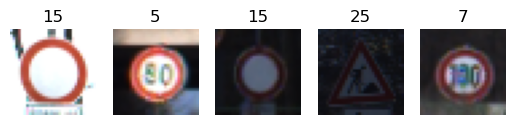

In [25]:
# Making predictions from the end point


%matplotlib inline
import random
import matplotlib.pyplot as plt

#Pre-processing the images

num_samples = 5
indices = random.sample(range(X_test.shape[0] - 1), num_samples)
images = X_test[indices]/255
labels = y_test[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

# Making predictions 

prediction = tf_predictor.predict(images.reshape(num_samples, 32, 32, 3))['predictions']
prediction = np.array(prediction)
predicted_label = prediction.argmax(axis=1)
print('Predicted labels are: {}'.format(predicted_label))

 - To improve the model accuracy we can do Dropout, adding more convolutional layers, and changing the size of the filters

In [ ]:

    # Selecting a random number
    index = np.random.randint(0, n_training)
    # reading and displaying an image with the selected index    
    axes[i].imshow( X_test[index])
    axes[i].set_title(y_test[index], fontsize = 15)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)


In [26]:
# Deleting the end-point
tf_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: trafficsignclassifier-2024-07-01-09-50-13
INFO:sagemaker:Deleting endpoint with name: trafficsignclassifier-2024-07-01-09-50-13
